Abgabe von: Mat.Nr.: 9452857 & 1113800

Before doing anything installing all needed dependencies

# Software requirements

Python 3.9–3.11

Version	Python version	Compiler	Build tools	cuDNN	CUDA
tensorflow-2.16.1	3.9-3.12	Clang 17.0.6	Bazel 6.5.0	8.9	12.3

!pip3 install pandas
!pip3 install scikit-learn
!pip3 install tensorflow==2.16.1
!pip3 install keras-tuner
!pip3 install matplotlib

# Aufgabe 1

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Import data

In [2]:
white_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-white.csv", delimiter=";")
red_raw = pd.read_csv(os.getcwd() + "/dataset/winequality-red.csv", delimiter=";")

In [3]:
white_raw

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


Split wine in Test and Training Data (75% / 25%)

In [4]:
white_training_Data, white_test_data, white_training_scores, white_test_scores = (train_test_split(white_raw.drop("quality", axis=1), white_raw['quality'],test_size=0.25, random_state=39))

red_training_Data, red_test_data, red_training_scores, red_test_scores = (train_test_split(red_raw.drop("quality", axis=1), red_raw['quality'],test_size=0.25, random_state=39))

Normalize the Data
Standard Scaler to Scale around 0
MIN May to Scale this than between 0-1

Some Functionality as tensorflow Normalization Layer

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, normalize, MinMaxScaler, StandardScaler

pipeline = Pipeline([
    ('scaler1', StandardScaler()),
    ('scaler2', MinMaxScaler())
])

white_training_Data_scaled = np.array(pipeline.fit_transform(white_training_Data))
white_training_scores = np.array(white_training_scores)
white_test_data_scaled = np.array(pipeline.transform(white_test_data))
white_test_scores = np.array(white_test_scores)

red_training_Data_scaled = np.array(pipeline.fit_transform(red_training_Data))
red_training_scores = np.array(red_training_scores)
red_test_data_scaled = np.array(pipeline.transform (red_test_data))
red_test_scores = np.array(red_test_scores)


In [6]:
white_training_Data_scaled

array([[0.33653846, 0.29411765, 0.13855422, ..., 0.35185185, 0.39285714,
        0.51612903],
       [0.24038462, 0.24509804, 0.12048193, ..., 0.38888889, 0.3452381 ,
        0.12903226],
       [0.34615385, 0.32352941, 0.39759036, ..., 0.30555556, 0.28571429,
        0.11290323],
       ...,
       [0.34615385, 0.11764706, 0.22289157, ..., 0.28703704, 0.23809524,
        0.19354839],
       [0.33653846, 0.04901961, 0.19277108, ..., 0.44444444, 0.1547619 ,
        0.19354839],
       [0.28846154, 0.10784314, 0.20481928, ..., 0.49074074, 0.27380952,
        0.79032258]])

# Aufgabe 3

https://www.tensorflow.org/tutorials/keras/regression#regression_using_a_dnn_and_multiple_inputs

## General Model definition

In [7]:
from math import sqrt

import keras
from keras import layers
from keras.src.models.cloning import clone_model

import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold

import keras_tuner

In [8]:
#Check and Print Tensorflow GPU Availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
def plot_loss(keras_regressor_model):
  plt.plot(keras_regressor_model.history['loss'], label='loss')
  plt.plot(keras_regressor_model.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [Wine Quality Score]')
  plt.legend()
  plt.grid(True)
  plt.show()
  
def plot_metrics(white_test_scores, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(white_test_scores, test_predictions)
    plt.xlabel('True Values [winequality-white]')
    plt.ylabel('Predictions [winequality-white]')
    lims = [0, 10]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

In [10]:
# Function to calculate model and print Bewertungsmetriken
def model_regressor_grid_calculator(estimator: any, param_grid: dict | list,
                               training_data: any, valid_data: any, training_scores: any, valid_scores: any):
    #select the best HyperParameters while using cross-validation for it (cv=5)
    grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, scoring="r2")
    grid_search.fit(training_data, training_scores)
    
    print("Beste Hyperparameter: " + str(grid_search.best_params_))
    
    # Select the best model from Grid Search
    optimal_model = grid_search.best_estimator_
    
    # Selected Params
    cv_results = pd.DataFrame(grid_search.cv_results_).loc[grid_search.best_index_]
    
    r2_score_cv = [cv_results['split0_test_score'], 
                   cv_results['split1_test_score'],
                   cv_results['split2_test_score'],
                   cv_results['split3_test_score'],
                   cv_results['split4_test_score'],
                   ]
    r2_score_cv_mean = cv_results['mean_test_score']
    r2_score_cv_std = cv_results['std_test_score']
    
    print('Cross Validation')
    print(f'- R^2: {r2_score_cv}')
    print(f'- R^2 Durchschnittlicher: {r2_score_cv_mean:.4f}')
    print(f'- R^2 Standardabweichung: {r2_score_cv_std:.4f}')
    print('\r\n')
    
    
    predicted_test_scores = optimal_model.predict(valid_data)
    
    r2_score_test = r2_score(valid_scores, predicted_test_scores)
    rmse_test = sqrt(mean_squared_error(valid_scores, predicted_test_scores))
    mape_test = mean_absolute_percentage_error(valid_scores, predicted_test_scores)
    
    print('Test:')
    print(f'- R^2: {r2_score_test:.4f}')
    print(f'- RMSE: {rmse_test:.2f}')
    print(f'- MAPE: {mape_test:.2%}')
    
    plot_loss(optimal_model)
    plot_metrics(valid_scores, predicted_test_scores)
    
    return cv_results, optimal_model

In [11]:
def create_model_tuner(hp, learning_rate):    
    # Konfiguriere die Verteilungsstrategie
    input_layer = layers.Input(shape=(11,))
    model = keras.Sequential([
        input_layer       
    ])
    
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=8, max_value=128, step=8),
                activation='relu',
            )
        )
    model.add(layers.Dense(1))#output
    
    model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[keras.metrics.mean_absolute_percentage_error, keras.metrics.R2Score])      
    
    return model

In [12]:
def evaluate_model_cv(learning_rate, model, training_data, training_scores, **kwargs):
    cv_scores = []
    models_history = []
    
    kfold = KFold(n_splits=5, shuffle=True) #Cross Validation cv=5
    for i, (train_index, test_index) in enumerate(kfold.split(training_data, training_scores)):
        local_model = clone_model(model)
        local_model.compile(
            loss=keras.losses.mean_squared_error, 
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            metrics=[keras.metrics.mean_absolute_percentage_error, keras.metrics.R2Score])
        
        model_history = local_model.fit(training_data[train_index], training_scores[train_index], batch_size=64, epochs=64, validation_data=(training_data[test_index], training_scores[test_index]), verbose=0, **kwargs)
        cv_scores.append(local_model.evaluate(training_data[test_index], training_scores[test_index]))
        models_history.append(model_history)
        
    cv_scores = np.array(cv_scores)
    r2_score_mean = np.mean(cv_scores[:, 2])
    
    return r2_score_mean


def evaluate_model_cv_print(learning_rate, model, training_data, training_scores, valid_data, valid_scores,  **kwargs):
    cv_scores = []
    models_history = []
    
    kfold = KFold(n_splits=5, shuffle=True) #Cross Validation cv=5
    for i, (train_index, test_index) in enumerate(kfold.split(training_data, training_scores)):
        local_model = clone_model(model)
        local_model.compile(
            loss=keras.losses.mean_squared_error, 
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
            metrics=[keras.metrics.mean_absolute_percentage_error, keras.metrics.R2Score])
        
        model_history = local_model.fit(training_data[train_index], training_scores[train_index], batch_size=64, epochs=64, validation_data=(training_data[test_index], training_scores[test_index]), verbose=0, **kwargs)
        cv_scores.append(local_model.evaluate(training_data[test_index], training_scores[test_index]))
        models_history.append((local_model, model_history))
        
    cv_scores = np.array(cv_scores)
        
    print('\r\nCross Validation')
    print(f'- R^2: {cv_scores[:, 2]}')
    print(f'- R^2 Durchschnittlicher: {np.mean(cv_scores[:, 2]):.4f}')
    print(f'- R^2 Standardabweichung: {np.std(cv_scores[:, 2]):.4f}')
    print('\r\n')
    
    #get best model
    best_model_index = np.argmax(cv_scores[:, 2])   #get best r2 score model
    optimal_model = models_history[best_model_index]
    
    predicted_test_scores = optimal_model[0].predict(valid_data)
    
    r2_score_test = r2_score(valid_scores, predicted_test_scores)
    rmse_test = sqrt(mean_squared_error(valid_scores, predicted_test_scores))
    mape_test = mean_absolute_percentage_error(valid_scores, predicted_test_scores)
    
    print('Test:')
    print(f'- R^2: {r2_score_test:.4f}')
    print(f'- RMSE: {rmse_test:.2f}')
    print(f'- MAPE: {mape_test:.2%}')
    
    plot_loss(optimal_model[1])
    plot_metrics(valid_scores, predicted_test_scores)
    
    return cv_scores, optimal_model
    
        

Ablauf Hyperparameter optimierung:
Fitting 5 folds for each of x candidates totalling 5x fits
Select best model based on r2 score mean (valid)

In [13]:
class HyperRegressor(keras_tuner.HyperModel):
    def build(self, hp):
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        return create_model_tuner(hp, learning_rate)

    def fit(self, hp, model, x, y, **kwargs):
        # Return a single float to maximize
        learning_rate = hp.get("lr")
        return evaluate_model_cv(learning_rate, model, x, y, **kwargs)

## White Wine

In [14]:
tuner = keras_tuner.RandomSearch(
    hypermodel=HyperRegressor(),
    objective = keras_tuner.Objective(name="val_r2_score", direction='max'),
    max_trials=50,
    overwrite=False,
    directory="wine_score_training",
    project_name="white",
)

Reloading Tuner from wine_score_training\white\tuner0.json


Following cell could be disabled if values should just be loaded

In [15]:
tuner.search(
    x=white_training_Data_scaled,
    y=white_training_scores,
)

tuner.results_summary()

Results summary
Results in wine_score_training\white
Showing 10 best trials
Objective(name="val_r2_score", direction="max")

Trial 37 summary
Hyperparameters:
lr: 0.004160564576348168
num_layers: 3
units_0: 40
units_1: 120
units_2: 120
units_3: 72
Score: 0.38073197603225706

Trial 28 summary
Hyperparameters:
lr: 0.0009031111745904648
num_layers: 3
units_0: 112
units_1: 88
units_2: 32
units_3: 40
Score: 0.37821786403656005

Trial 36 summary
Hyperparameters:
lr: 0.0011161189472157437
num_layers: 4
units_0: 96
units_1: 24
units_2: 96
units_3: 8
Score: 0.3742436408996582

Trial 43 summary
Hyperparameters:
lr: 0.0007000914691723327
num_layers: 4
units_0: 80
units_1: 112
units_2: 80
units_3: 120
Score: 0.3724264144897461

Trial 32 summary
Hyperparameters:
lr: 0.0044008493021638305
num_layers: 4
units_0: 64
units_1: 104
units_2: 104
units_3: 72
Score: 0.3698438763618469

Trial 46 summary
Hyperparameters:
lr: 0.0005711737114621607
num_layers: 4
units_0: 112
units_1: 40
units_2: 48
units_3: 64


In [16]:
best_model = tuner.get_best_models()[0]
best_model.summary()

C:\GitClones\TINF21C_Maschinelles-Lernen\Programmierabgabe 2\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │         4,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,041 (78.29 KB)

 Trainable params: 20,041 (78.29 KB)

 Non-trainable params: 0 (0.00 B)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.5438 - mean_absolute_percentage_error: 10.2642 - r2_score: 0.3517
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.5192 - mean_absolute_percentage_error: 9.7186 - r2_score: 0.3063
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.4766 - mean_absolute_percentage_error: 9.5811 - r2_score: 0.3484
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.5257 - mean_absolute_percentage_error: 9.7873 - r2_score: 0.3390
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.4677 - mean_absolute_percentage_error: 9.3102 - r2_score: 0.3683

Cross Validation
- R^2: [0.37257862 0.35796833 0.37269026 0.37575996 0.39454073]
- R^2 Durchschnittlicher: 0.3747
- R^2 Standardabweichung: 0.0117


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
Test:
- R^2: 0.3085
- RMSE: 0.74
- MAPE: 10.24%


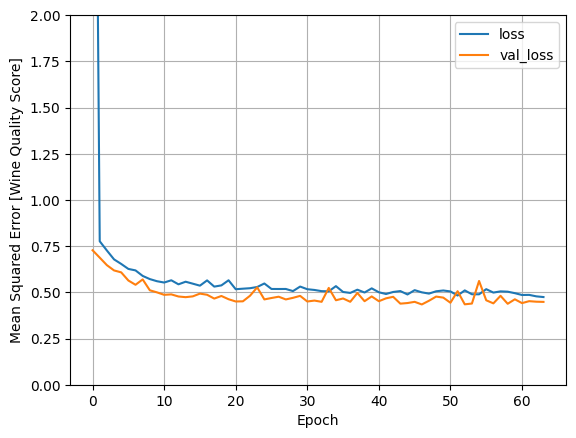

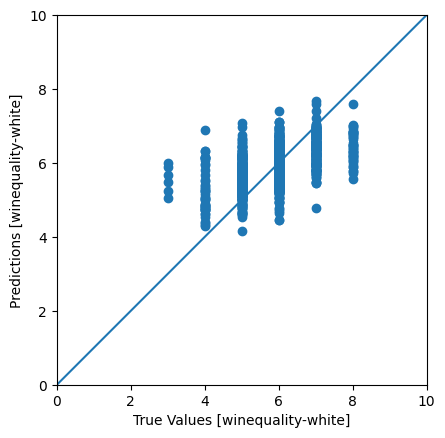

CPU times: total: 5.44 s
Wall time: 18.4 s


(array([[ 0.50871283, 10.06041527,  0.37257862],
        [ 0.49418965,  9.70754814,  0.35796833],
        [ 0.49953073, 10.05245018,  0.37269026],
        [ 0.49732003,  9.53590488,  0.37575996],
        [ 0.44828007,  9.21850491,  0.39454073]]),
 (<Sequential name=sequential_1, built=True>,
  <keras.src.callbacks.history.History at 0x1fd75745880>))

In [17]:
%%time
#Retrain best Model
best_hp = tuner.get_best_hyperparameters()[0]
best_model = HyperRegressor().build(best_hp)
learning_rate = best_hp.get("lr")
best_model_history = evaluate_model_cv_print(learning_rate, best_model, white_training_Data_scaled, white_training_scores, white_test_data_scaled, white_test_scores)
best_model_history

In [18]:
best_hp.values

{'lr': 0.004160564576348168,
 'num_layers': 3,
 'units_0': 40,
 'units_1': 120,
 'units_2': 120,
 'units_3': 72}

## RED Wine

In [19]:
red_tuner = keras_tuner.RandomSearch(
    hypermodel=HyperRegressor(),
    objective = keras_tuner.Objective(name="val_r2_score", direction='max'),
    max_trials=50,
    overwrite=False,
    directory="wine_score_training",
    project_name="red",
)

Reloading Tuner from wine_score_training\red\tuner0.json


In [20]:
red_tuner.search(
    x=red_training_Data_scaled,
    y=red_training_scores,
)

red_tuner.results_summary()

Results summary
Results in wine_score_training\red
Showing 10 best trials
Objective(name="val_r2_score", direction="max")

Trial 45 summary
Hyperparameters:
lr: 0.006859377633228802
num_layers: 4
units_0: 104
units_1: 88
units_2: 8
units_3: 80
Score: 0.34972081184387205

Trial 17 summary
Hyperparameters:
lr: 0.0018925128438043142
num_layers: 2
units_0: 88
units_1: 88
units_2: 96
units_3: 24
Score: 0.34657400846481323

Trial 09 summary
Hyperparameters:
lr: 0.004029414387684745
num_layers: 3
units_0: 40
units_1: 120
units_2: 88
units_3: 80
Score: 0.34105840921401975

Trial 19 summary
Hyperparameters:
lr: 0.0032409501212600873
num_layers: 2
units_0: 48
units_1: 56
units_2: 120
units_3: 32
Score: 0.3389271378517151

Trial 08 summary
Hyperparameters:
lr: 0.00306562330900601
num_layers: 3
units_0: 88
units_1: 88
units_2: 48
units_3: 112
Score: 0.33255308866500854

Trial 40 summary
Hyperparameters:
lr: 0.0016228511966086888
num_layers: 3
units_0: 32
units_1: 16
units_2: 40
units_3: 32
Score: 

In [21]:
best_red_model = red_tuner.get_best_models()[0]
best_red_model.summary()

C:\GitClones\TINF21C_Maschinelles-Lernen\Programmierabgabe 2\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 104)            │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │         9,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 80)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,001 (46.88 KB)

 Trainable params: 12,001 (46.88 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.4803 - mean_absolute_percentage_error: 9.4713 - r2_score: 0.2659
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 0.6028 - mean_absolute_percentage_error: 10.7124 - r2_score: 0.1022
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.6032 - mean_absolute_percentage_error: 10.8667 - r2_score: -0.1219
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.5118 - mean_absolute_percentage_error: 9.9967 - r2_score: 0.3075
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.3394 - mean_absolute_percentage_error: 8.6419 - r2_score: 0.3416

Cross Validation
- R^2: [ 0.31765223  0.22227609 -0.13576066  0.29424477  0.30436295]
- R^2 Durchschnittlicher: 0.2006
- R^2 Standardabweichung: 0.1714


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test:
- R^2: 0.4113
- RMSE: 0.67
- MAPE: 9.18%


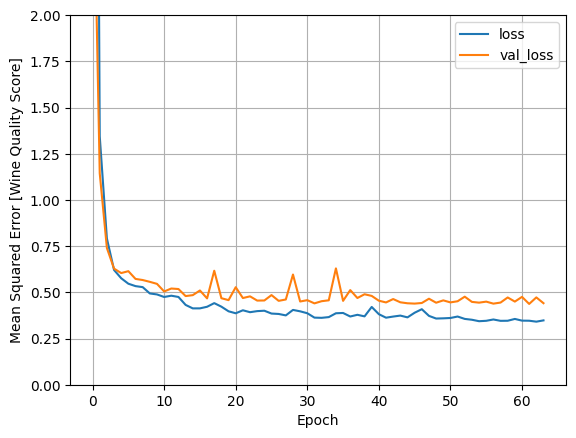

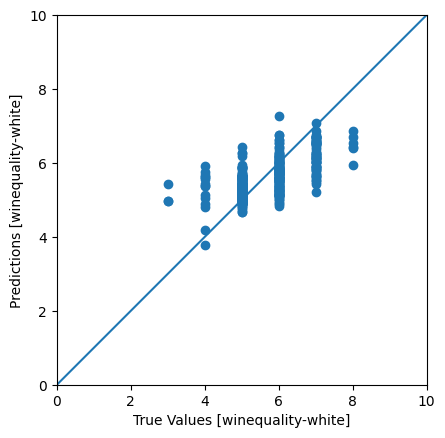

CPU times: total: 4.92 s
Wall time: 13.1 s


(array([[ 0.44120353,  9.22926998,  0.31765223],
        [ 0.51583701,  9.80092812,  0.22227609],
        [ 0.60319722, 10.68018436, -0.13576066],
        [ 0.48166588,  9.58721352,  0.29424477],
        [ 0.38558829,  8.89576626,  0.30436295]]),
 (<Sequential name=sequential_1, built=True>,
  <keras.src.callbacks.history.History at 0x1fd732c2ab0>))

In [22]:
%%time
#Retrain best Model
best_red_hp = red_tuner.get_best_hyperparameters()[0]
best_red_model = HyperRegressor().build(best_red_hp)
red_learning_rate = best_red_hp.get("lr")
best_red_model_history = evaluate_model_cv_print(red_learning_rate, best_model, red_training_Data_scaled, red_training_scores, red_test_data_scaled, red_test_scores)
best_red_model_history